In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import time
import os
import copy

# Logging time, process
from tqdm import tqdm


class VGG11(torch.nn.Module):
    
    '''
        Define a VGG with 11 layers
        - Input   : 28x28x1 (original 224x224 RGB)
        - Conv1_1 : 28x28x1  -> 28x28x64   
        - Pool1   : 28x28x64 -> 14x14x64
        - Conv2_1 : 14x14x64 -> 14x14x128
        - Pool2   : 14x14x128-> 7x7x128
        - Conv3_1 : 7x7x128  -> 7x7x256
        - Conv3_2 : 7x7x256  -> 7x7x256
        - Pool3   : 7x7x256  -> 5x5x256    
        - Conv4_1 : 5x5x256  -> 5x5x512
        - Conv4_2 : 5x5x256  -> 5x5x512
        - Pool4   : 5x5x512  -> 3x3x512  
        - Conv5_1 : 3x3x256  -> 3x3x512
        - Conv5_2 : 3x3x256  -> 3x3x512
        - Pool5   : 3x3x512  -> 1x1x512  
        - FC1     : 3x3x512  -> 256
        - FC2     : 256      -> 256
        - FC3     : 256      -> 10
    '''
    
    def __init__(self):
        super().__init__()
        
        self.conv1_1 = torch.nn.Conv2d(in_channels = 1, 
                                       out_channels = 64, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
    
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        
        self.conv2_1 = torch.nn.Conv2d(in_channels = 64, 
                                       out_channels = 128, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv3_1 = torch.nn.Conv2d(in_channels = 128, 
                                       out_channels = 256, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv3_2 = torch.nn.Conv2d(in_channels = 256, 
                                       out_channels = 256, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool3 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv4_1 = torch.nn.Conv2d(in_channels = 256, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv4_2 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool4 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.conv5_1 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.conv5_2 = torch.nn.Conv2d(in_channels = 512, 
                                       out_channels = 512, 
                                       kernel_size = 3, 
                                       stride  = 1,
                                       padding = 1)
        
        self.pool5 = torch.nn.MaxPool2d(kernel_size = 2, 
                                        stride = 2, 
                                        padding = 0)
        
        self.fc1 = torch.nn.Linear(512*1*1, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 10)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1_1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.pool4(x)
        
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.pool5(x)
        
        # Flatten CNN output to feed to the fully-connected layer
        x = x.view(-1, 512*1*1)
        
        # Use ReLU activation for first FC layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output with 10 classes, use log_softmax
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return(x)

In [3]:
# Define the transform object to tranform image to tensor and normalize
# (Can also add others for data augmentation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the data from MNIST
# Otherwise, to load from disk, use datasets.ImageFolder
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1/10..  Training Loss: 0.892..  Training Acc : 0.678.. Test Loss: 0.211..  Test Accuracy: 0.942


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2/10..  Training Loss: 0.194..  Training Acc : 0.948.. Test Loss: 0.189..  Test Accuracy: 0.952


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3/10..  Training Loss: 0.152..  Training Acc : 0.959.. Test Loss: 0.142..  Test Accuracy: 0.964


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4/10..  Training Loss: 0.132..  Training Acc : 0.964.. Test Loss: 0.228..  Test Accuracy: 0.938


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 5/10..  Training Loss: 0.127..  Training Acc : 0.967.. Test Loss: 0.160..  Test Accuracy: 0.954


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 6/10..  Training Loss: 0.133..  Training Acc : 0.966.. Test Loss: 0.092..  Test Accuracy: 0.976


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 7/10..  Training Loss: 0.093..  Training Acc : 0.975.. Test Loss: 0.092..  Test Accuracy: 0.977


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 8/10..  Training Loss: 0.112..  Training Acc : 0.970.. Test Loss: 0.101..  Test Accuracy: 0.971


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 9/10..  Training Loss: 0.080..  Training Acc : 0.978.. Test Loss: 0.093..  Test Accuracy: 0.977


100%|██████████| 938/938 [35:48<00:00,  2.08s/it]


Epoch: 10/10..  Training Loss: 0.084..  Training Acc : 0.978.. Test Loss: 0.095..  Test Accuracy: 0.975


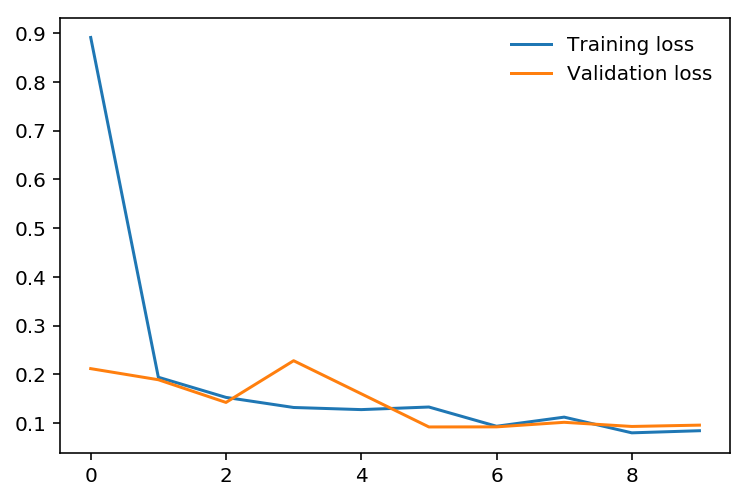

In [5]:
# Define the model, loss and optimizer
model = VGG11()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


num_of_epochs = 10
train_losses = []
test_losses = []
for e in range(num_of_epochs):
    running_loss = 0
    train_acc = 0
    for images, labels in tqdm(trainloader):
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        # Count equals and calculate accuracy
        equals = top_class == labels.view(top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation to speed up
        with torch.no_grad():
            for images, labels in testloader:

                # set model to evaluation mode
                # this will turn off the dropout by change the drop_prob to 0
                model.eval()

                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # Get top 1 class

                # Count equals and calculate accuracy
                equals = top_class == labels.view(top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, num_of_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Acc : {:.3f}..".format(train_acc/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        # set model back to train mode
        # this will turn on the dropout
        model.train()

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)